In [1]:
import sys
sys.path.append('..')

# Attack imports
from simba import simba_attack_image
from hsja import hop_skip_jump_attack

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Other imports
from datetime import datetime
import logging

/Users/neddamj/miniforge3/envs/nhash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-02 13:55:06.069704: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[INFO] Images saved
[INFO] RAM Disk Already Exists...
[INFO] RAM Disk Cleared...
[INFO] Files moved to temp RAM...


In [6]:
# SIMBA Hyperparams
simba_epsilon = 0.9
simba_hamming_threshold = 16
simba_max_steps = 50

# HSJA Hyperparams
hsja_max_steps = 2
hsja_grad_queries = 20
hsja_l2_threshold = 17
hsja_hamming_threshold = int(0.1 * 96 + 0.5)                # 10% ~ 10 and 50% = 48

In [7]:
# Configure logging
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")
logging.basicConfig(filename=f'../../logs/targeted/Eps-{simba_epsilon}_Bits-{simba_hamming_threshold}_{dt_string}.log',
                    format='%(asctime)s %(message)s',
                    level='DEBUG',
                    filemode='w',
                    force=True)
logger = logging.getLogger()
logger.info(f'Epsilon: {simba_epsilon}\tMismatched Bits Threshold: {simba_hamming_threshold}\n')

In [8]:
def joint_attack(img_path,
           target_img_path,
           epsilon, 
           logger,
           max_mismatched_bits,
           simba_max_steps,
           hsja_max_steps,
           grad_queries,
           l2_threshold,
           hamming_threshold):
    # Soft-label attack
    (simba_filename, simba_queries) = simba_attack_image(img_path=img_path, 
                                          target_path=target_img_path,
                                          eps=epsilon, 
                                          logger=logger,
                                          max_steps=simba_max_steps,
                                          mismatched_threshold=max_mismatched_bits)
    # Hard-label attack
    (adv_img, hsja_queries) = hop_skip_jump_attack(orig_img_path=target_img_path, 
                                target_img_path=simba_filename, 
                                max_iters=hsja_max_steps, 
                                grad_queries=grad_queries, 
                                l2_threshold=l2_threshold, 
                                hamming_threshold=hamming_threshold)
    # Load the original image as well as the noisy adv. image outputted by simba
    orig_img, simba_img = utils.load_img(img_path), utils.load_img(simba_filename)
    return orig_img, simba_img, adv_img, simba_queries, hsja_queries

In [10]:
# Format the path to the input image and target image
img_path = '../../images/1.jpeg' 
_, _, _, _, path, filetype = img_path.split('.')
img_path = path.split('/')
img_path = f'{folder_path}{img_path[2]}.{filetype}'

target_img_path = '../../images/3.jpeg' 
_, _, _, _, path, filetype = target_img_path.split('.')
target_img_path = path.split('/')
target_img_path = f'{folder_path}{target_img_path[2]}.{filetype}'

# Attack NeuralHash 
orig_img, simba_img, adv_img, simba_num_queries, hsja_num_queries = joint_attack(img_path,
                                                                        target_img_path, 
                                                                        simba_epsilon, 
                                                                        logger, 
                                                                        simba_hamming_threshold, 
                                                                        simba_max_steps, 
                                                                        hsja_max_steps, 
                                                                        hsja_grad_queries, 
                                                                        hsja_l2_threshold, 
                                                                        hsja_hamming_threshold)


1| Add Hamming Dist: 48	 Sub Hamming Dist: 49
2| Add Hamming Dist: 48	 Sub Hamming Dist: 49
3| Add Hamming Dist: 48	 Sub Hamming Dist: 48
4| Add Hamming Dist: 49	 Sub Hamming Dist: 48
5| Add Hamming Dist: 48	 Sub Hamming Dist: 48
6| Add Hamming Dist: 48	 Sub Hamming Dist: 48
7| Add Hamming Dist: 48	 Sub Hamming Dist: 48
8| Add Hamming Dist: 48	 Sub Hamming Dist: 48
9| Add Hamming Dist: 48	 Sub Hamming Dist: 48
10| Add Hamming Dist: 48	 Sub Hamming Dist: 48
11| Add Hamming Dist: 48	 Sub Hamming Dist: 48
12| Add Hamming Dist: 48	 Sub Hamming Dist: 48
13| Add Hamming Dist: 48	 Sub Hamming Dist: 48
14| Add Hamming Dist: 48	 Sub Hamming Dist: 48
15| Add Hamming Dist: 48	 Sub Hamming Dist: 48
16| Add Hamming Dist: 48	 Sub Hamming Dist: 48
17| Add Hamming Dist: 48	 Sub Hamming Dist: 48
18| Add Hamming Dist: 48	 Sub Hamming Dist: 48
19| Add Hamming Dist: 48	 Sub Hamming Dist: 48
20| Add Hamming Dist: 48	 Sub Hamming Dist: 48
21| Add Hamming Dist: 48	 Sub Hamming Dist: 48
22| Add Hamming Dist: 

In [11]:
# Attack Matrics
orig_img, target_img = utils.load_img(img_path), utils.load_img(target_img_path)
orig_hash, simba_hash, adv_hash, target_hash = utils.compute_hash(orig_img), utils.compute_hash(simba_img), utils.compute_hash(adv_img), utils.compute_hash(target_img)
simba_hamming_dist = utils.distance(orig_hash, simba_hash, "hamming")
final_hamming_dist = utils.distance(target_hash, adv_hash, "hamming")
simba_l2_dist = utils.distance(orig_img, simba_img, 'l2')
final_l2_dist = utils.distance(orig_img, adv_img, 'l2')
print(f'Simba Hamming Dist: {simba_hamming_dist} \tFinal Hamming Dist: {final_hamming_dist}')
print(f"Simba L2 Dist: {simba_l2_dist} \tFinal L2 Dist: {final_l2_dist}\n")
if final_hamming_dist <= hsja_hamming_threshold and final_l2_dist < hsja_l2_threshold:
    print('The attack was successful\n')
else:
    print('The attack failed\n')

total_queries = simba_num_queries + hsja_num_queries
print(f'Total Queries: {total_queries}')

Simba Hamming Dist: 0 	Final Hamming Dist: 17
Simba L2 Dist: 1.7869835660359579 	Final L2 Dist: 162.84982028502688

The attack failed

Total Queries: 52


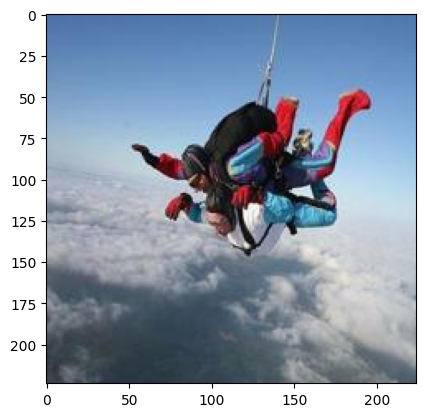

In [12]:
plt.imshow(orig_img)

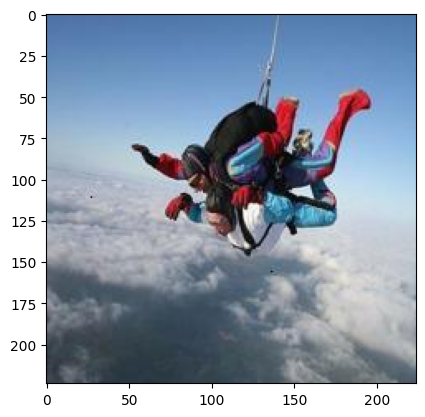

In [13]:
plt.imshow(simba_img)

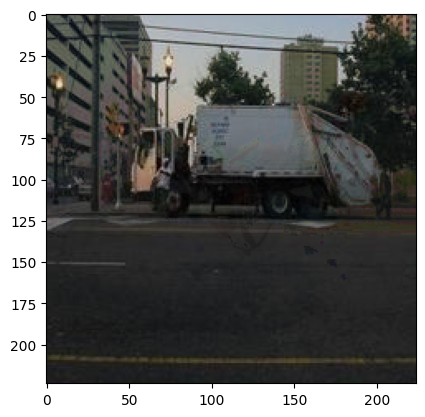

In [14]:
plt.imshow(adv_img.astype(np.uint8))